In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("./"))
import librosa
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import skew
import time
SAMPLE_RATE = 44100

from tqdm import tqdm
import scipy
data_path = './'
# ss = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

['dnnmult.py', 'Hybrid Multi-layer Derived.ipynb', 'CNN No_Hierarchy_torch.ipynb', 'model_40.pt', 'hierarchical_cnn.pt', '.DS_Store', 'CNN_Non_Hierarchical.pt', 'CNN No-Hierarchy OvA.ipynb', 'CNN No-Hierarchy_reproduce_new.ipynb', 'CNN Hierarchical reproduce.ipynb', 'CNN Multi-layer.ipynb', 'cnnmult.py', 'CNN No-Hierarchy.ipynb', 'SVM.ipynb', 'hybmulder.py', 'ablation_analysis.ipynb', 'Hybrid Multi-layer D+B.ipynb', 'model_h5', 'DNN_baseline.ipynb', 'DNN Multi-layer.ipynb', 'DNN No-Hierarchy.ipynb', '.ipynb_checkpoints', 'SVM No-Hierarchy OvA.ipynb', 'model_60.pt', 'DNN Quantized.ipynb', 'RNN', 'SVM', 'model_json', 'KNN', 'Feature Reduction Tests.ipynb', 'SVM No-Hierarchy.ipynb', 'mixd_mult.py', 'train_df.csv', 'Hybrid Multi-layer D+B No Prob.ipynb', 'load_blockwise.py', 'RFC', 'AUC-ROC Curve.ipynb', 'DNN', 'CNN', 'CNN No-Hierarchy_reproduce.ipynb']


In [2]:
#loading data
audio_train_files = os.listdir('../../ESC-50/audio/')
# audio_test_files = os.listdir('./audio_test')

train = pd.read_csv('../../ESC-50/meta/esc50.csv')
# submission = pd.read_csv('./sample_submission.csv')

In [3]:
def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

#returns mfcc features with mean and standard deviation along time
def get_mfcc_rms(name, path):
    b, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.mfcc(b, sr = SAMPLE_RATE, n_mfcc=80, lifter=140)
        #Compute root-mean-square (RMS) value for each frame, either from the audio samples
        rms = librosa.feature.rms(b)
        #zero_crossing_rate
        zcr = librosa.feature.zero_crossing_rate(b)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1), skew(gmm, axis = 1), np.median(gmm, axis = 1), np.mean(rms, axis=1), np.std(rms, axis=1), skew(rms, axis = 1), np.median(rms, axis = 1), np.mean(zcr, axis=1), np.std(zcr, axis=1), skew(zcr, axis = 1), np.median(zcr, axis = 1))) )
    except:
        print('bad file')
        return pd.Series([0]*80)

In [4]:
#preparing data
train_data = pd.DataFrame()
train_data['fname'] = train['filename']

s_time = time.time()
train_data = train_data['fname'].apply(get_mfcc_rms, path='../../ESC-50/audio/')
print('done loading train mfcc')
e_time = time.time()
print(e_time - s_time)

train_data['fname'] = train['filename']
train_data['label'] = train['target']

done loading train mfcc
46.152095079422


In [5]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,320,321,322,323,324,325,326,327,fname,label
0,-1495.460449,33.981899,-38.013977,-31.215279,-26.817242,2.695553,-23.469969,-3.666011,7.795646,5.667233,...,0.007518,0.040822,6.140847,0.000000,0.007329,0.027503,4.345379,0.000000,1-100032-A-0.wav,0
1,-654.925049,355.146790,-611.110352,225.396408,-352.620056,-179.832291,-444.408508,-245.108353,-175.657227,-291.888489,...,0.048209,0.038197,2.212040,0.033864,0.157994,0.022784,0.254124,0.155273,1-100038-A-14.wav,14
2,-78.071724,424.462738,-230.804398,283.980255,-198.484894,132.904099,-101.119019,279.514099,-174.520752,314.197510,...,0.271365,0.046708,-1.110760,0.279471,0.199469,0.029614,-4.015615,0.206543,1-100210-A-36.wav,36
3,-79.893417,431.904388,-246.030975,307.673462,-232.414139,190.786209,-127.077171,301.930725,-183.575775,273.924591,...,0.275260,0.066043,-1.457496,0.298971,0.202079,0.021309,-1.740700,0.207031,1-100210-B-36.wav,36
4,-1199.333130,597.290466,131.056137,379.930908,26.223122,117.693100,-34.786598,1.109512,-134.291672,166.270142,...,0.008845,0.006442,2.185313,0.006792,0.027574,0.010662,0.818237,0.025391,1-101296-A-19.wav,19


In [6]:
#Features from LightGBM baseline kernel: https://www.kaggle.com/opanichev/lightgbm-baseline
# MAPk from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


def extract_features(files, path):
    features = {}

    cnt = 0
    for f in tqdm(files):
        features[f] = {}

        fs, data = scipy.io.wavfile.read(os.path.join(path, f))

        abs_data = np.abs(data)
        diff_data = np.diff(data)

        def calc_part_features(data, n=2, prefix=''):
            f_i = 1
            for i in range(0, len(data), len(data)//n):
                features[f]['{}mean_{}_{}'.format(prefix, f_i, n)] = np.mean(data[i:i + len(data)//n])
                features[f]['{}std_{}_{}'.format(prefix, f_i, n)] = np.std(data[i:i + len(data)//n])
                features[f]['{}min_{}_{}'.format(prefix, f_i, n)] = np.min(data[i:i + len(data)//n])
                features[f]['{}max_{}_{}'.format(prefix, f_i, n)] = np.max(data[i:i + len(data)//n])

        features[f]['len'] = len(data)
        if features[f]['len'] > 0:
            n = 1
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')

            n = 2
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')

            n = 3
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')


        cnt += 1

        # if cnt >= 1000:
        #     break

    features = pd.DataFrame(features).T.reset_index()
    features.rename(columns={'index': 'fname'}, inplace=True)
    
    return features

path = "../../ESC-50/audio/"
train_files = train.filename.values
train_features = extract_features(train_files, path)

100%|██████████| 2000/2000 [00:19<00:00, 100.33it/s]


In [7]:
train_data = train_data.merge(train_features, on='fname', how='left')
train_data.to_csv("./train_df.csv")
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,min_1_3,max_1_3,abs_mean_1_3,abs_std_1_3,abs_min_1_3,abs_max_1_3,diff_mean_1_3,diff_std_1_3,diff_min_1_3,diff_max_1_3
0,-1495.460449,33.981899,-38.013977,-31.215279,-26.817242,2.695553,-23.469969,-3.666011,7.795646,5.667233,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,-654.925049,355.146790,-611.110352,225.396408,-352.620056,-179.832291,-444.408508,-245.108353,-175.657227,-291.888489,...,-5336.0,4553.0,783.556857,624.554197,0.0,5336.0,-1099.5,137.5,-1237.0,-962.0
2,-78.071724,424.462738,-230.804398,283.980255,-198.484894,132.904099,-101.119019,279.514099,-174.520752,314.197510,...,-32141.0,32767.0,7447.340422,5258.252535,0.0,32767.0,-8262.5,921.5,-9184.0,-7341.0
3,-79.893417,431.904388,-246.030975,307.673462,-232.414139,190.786209,-127.077171,301.930725,-183.575775,273.924591,...,-32768.0,32767.0,6052.735306,5143.856077,-32768.0,32767.0,-286.0,777.0,-1063.0,491.0
4,-1199.333130,597.290466,131.056137,379.930908,26.223122,117.693100,-34.786598,1.109512,-134.291672,166.270142,...,-1142.0,1049.0,158.945646,137.849542,0.0,1142.0,-26.0,5.0,-31.0,-21.0


In [8]:
#Functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
# Construct features set
train_data = pd.read_csv("./train_df.csv")
X = train_data.drop(['label', 'fname'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(train_data.label.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in train_data.label.values])

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(n_estimators = 150)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)
rfc.fit(X_train, y_train)
#more functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
def proba2labels(preds, i2c, k=3):
    ans = []
    ids = []
    for p in preds:
        idx = np.argsort(p)[::-1]
        ids.append([i for i in idx[:k]])
        ans.append(' '.join([i2c[i] for i in idx[:k]]))

    return ans, ids
#checking the accuracy of the model
print(rfc.score(X_val, y_val))

0.6425


In [10]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(366, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 50)
        self.norm1 = nn.BatchNorm1d(128)
        self.norm2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout2d(p=0.2)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [12]:
# load data:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class audiodata(Dataset):
    def __init__(self):
        
        self.data = pd.read_csv("./train_df.csv")
        X = self.data.drop(['label', 'fname'], axis=1)
        feature_names = list(X.columns)
        X = X.values
        labels = np.sort(np.unique(train_data.label.values))
        num_class = len(labels)
        c2i = {}
        i2c = {}
        for i, c in enumerate(labels):
            c2i[c] = i
            i2c[i] = c
        y = np.array([c2i[x] for x in train_data.label.values])
        
            
    
        self.data_list = X
        self.label_list = y
        
#         print(self.data_list)
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        
        data = self.data_list[index]
        label= self.label_list[index] 
        label = np.asarray(label)
#         print(data.shape,label.shape)
        return data, label

data = audiodata()
# data.__getitem__(1)

2000 2000


In [13]:
#### new spectrogram
import torch.optim as optim
import torch
import time
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler

model = Net()
print(model)
model = model#.cuda()
pp=0
for p in list(model.parameters()):
    nnd=1
    for s in list(p.size()):
        nnd = nnd*s
    pp += nnd
print(pp)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0000)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

random_seed= 42
shuffle_dataset = True
dataset_size = 2000
batch_size = 128

validation_split = .2
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
dataset  = audiodata()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(600):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(testloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs#.cuda()
        labels = labels#.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    running_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs#.cuda()
        labels = labels#.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
print('Finished Training')

Net(
  (fc1): Linear(in_features=366, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=50, bias=True)
  (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (softmax): Softmax(dim=None)
)
58866
2000 2000
===========Phase: Val============
Validation Time: 0.012563943862915039
Epoch: 0  val_loss: 3.912250280380249
Epoch: 0  val_accuracy: 0.001953125
===========Phase: Train============
Training Time: 0.7027456760406494
Epoch: 0  train_loss: 3.9057939786177416
Epoch: 0  train_accuracy: 0.05889423076923077

===========Phase: Val============
Validation Time: 0.010488510131835938
Epoch: 1  val_loss: 3.900820255279541
Epoch: 1  val_accuracy: 0.078125
===========Phase: Train============
Training Time: 0.0625457763671875
Epoch: 1  train_lo

===========Phase: Train============
Training Time: 0.06468534469604492
Epoch: 27  train_loss: 3.469591159086961
Epoch: 27  train_accuracy: 0.5042067307692307

===========Phase: Val============
Validation Time: 0.01033163070678711
Epoch: 28  val_loss: 3.629321038722992
Epoch: 28  val_accuracy: 0.3671875
===========Phase: Train============
Training Time: 0.06160235404968262
Epoch: 28  train_loss: 3.4606979810274563
Epoch: 28  train_accuracy: 0.5144230769230769

===========Phase: Val============
Validation Time: 0.010458946228027344
Epoch: 29  val_loss: 3.617644786834717
Epoch: 29  val_accuracy: 0.349609375
===========Phase: Train============
Training Time: 0.06274962425231934
Epoch: 29  train_loss: 3.450636680309589
Epoch: 29  train_accuracy: 0.5294471153846154

===========Phase: Val============
Validation Time: 0.009876251220703125
Epoch: 30  val_loss: 3.652681052684784
Epoch: 30  val_accuracy: 0.32421875
===========Phase: Train============
Training Time: 0.06345605850219727
Epoch: 30  

===========Phase: Train============
Training Time: 0.06447720527648926
Epoch: 54  train_loss: 3.206138647519625
Epoch: 54  train_accuracy: 0.7734375

===========Phase: Val============
Validation Time: 0.010095357894897461
Epoch: 55  val_loss: 3.5275001525878906
Epoch: 55  val_accuracy: 0.44921875
===========Phase: Train============
Training Time: 0.06241154670715332
Epoch: 55  train_loss: 3.20133559520428
Epoch: 55  train_accuracy: 0.7764423076923077

===========Phase: Val============
Validation Time: 0.010122537612915039
Epoch: 56  val_loss: 3.5309298038482666
Epoch: 56  val_accuracy: 0.46484375
===========Phase: Train============
Training Time: 0.06111001968383789
Epoch: 56  train_loss: 3.196694410764254
Epoch: 56  train_accuracy: 0.7764423076923077

===========Phase: Val============
Validation Time: 0.00977015495300293
Epoch: 57  val_loss: 3.4987664818763733
Epoch: 57  val_accuracy: 0.517578125
===========Phase: Train============
Training Time: 0.06290674209594727
Epoch: 57  train_l

===========Phase: Train============
Training Time: 0.0649871826171875
Epoch: 81  train_loss: 3.115365505218506
Epoch: 81  train_accuracy: 0.8527644230769231

===========Phase: Val============
Validation Time: 0.010698318481445312
Epoch: 82  val_loss: 3.525300920009613
Epoch: 82  val_accuracy: 0.4609375
===========Phase: Train============
Training Time: 0.06711220741271973
Epoch: 82  train_loss: 3.1125094340397763
Epoch: 82  train_accuracy: 0.8557692307692307

===========Phase: Val============
Validation Time: 0.010382652282714844
Epoch: 83  val_loss: 3.5076650977134705
Epoch: 83  val_accuracy: 0.48828125
===========Phase: Train============
Training Time: 0.06182694435119629
Epoch: 83  train_loss: 3.1124129478748026
Epoch: 83  train_accuracy: 0.8515625

===========Phase: Val============
Validation Time: 0.010561466217041016
Epoch: 84  val_loss: 3.496749520301819
Epoch: 84  val_accuracy: 0.4921875
===========Phase: Train============
Training Time: 0.06553053855895996
Epoch: 84  train_los

===========Phase: Train============
Training Time: 0.06719422340393066
Epoch: 108  train_loss: 3.08287840623122
Epoch: 108  train_accuracy: 0.8731971153846154

===========Phase: Val============
Validation Time: 0.01073908805847168
Epoch: 109  val_loss: 3.499119520187378
Epoch: 109  val_accuracy: 0.46875
===========Phase: Train============
Training Time: 0.06673669815063477
Epoch: 109  train_loss: 3.081702103981605
Epoch: 109  train_accuracy: 0.8731971153846154

===========Phase: Val============
Validation Time: 0.011876344680786133
Epoch: 110  val_loss: 3.467065751552582
Epoch: 110  val_accuracy: 0.521484375
===========Phase: Train============
Training Time: 0.06339645385742188
Epoch: 110  train_loss: 3.07985833974985
Epoch: 110  train_accuracy: 0.8768028846153846

===========Phase: Val============
Validation Time: 0.0102691650390625
Epoch: 111  val_loss: 3.5281479954719543
Epoch: 111  val_accuracy: 0.443359375
===========Phase: Train============
Training Time: 0.06455373764038086
Epoc

===========Phase: Train============
Training Time: 0.06435203552246094
Epoch: 135  train_loss: 3.0533579129439135
Epoch: 135  train_accuracy: 0.9044471153846154

===========Phase: Val============
Validation Time: 0.010954856872558594
Epoch: 136  val_loss: 3.4743382334709167
Epoch: 136  val_accuracy: 0.5078125
===========Phase: Train============
Training Time: 0.06656885147094727
Epoch: 136  train_loss: 3.0516346051142764
Epoch: 136  train_accuracy: 0.9080528846153846

===========Phase: Val============
Validation Time: 0.011029958724975586
Epoch: 137  val_loss: 3.4765735864639282
Epoch: 137  val_accuracy: 0.505859375
===========Phase: Train============
Training Time: 0.06305098533630371
Epoch: 137  train_loss: 3.0501852952516995
Epoch: 137  train_accuracy: 0.9068509615384616

===========Phase: Val============
Validation Time: 0.01030421257019043
Epoch: 138  val_loss: 3.469717502593994
Epoch: 138  val_accuracy: 0.5625
===========Phase: Train============
Training Time: 0.06426048278808594

===========Phase: Train============
Training Time: 0.06499791145324707
Epoch: 162  train_loss: 3.032560238471398
Epoch: 162  train_accuracy: 0.9224759615384616

===========Phase: Val============
Validation Time: 0.010480165481567383
Epoch: 163  val_loss: 3.4475306272506714
Epoch: 163  val_accuracy: 0.5546875
===========Phase: Train============
Training Time: 0.06485962867736816
Epoch: 163  train_loss: 3.0335577451265774
Epoch: 163  train_accuracy: 0.9224759615384616

===========Phase: Val============
Validation Time: 0.015800952911376953
Epoch: 164  val_loss: 3.4602372646331787
Epoch: 164  val_accuracy: 0.52734375
===========Phase: Train============
Training Time: 0.08054637908935547
Epoch: 164  train_loss: 3.0334085867955136
Epoch: 164  train_accuracy: 0.9224759615384616

===========Phase: Val============
Validation Time: 0.010926008224487305
Epoch: 165  val_loss: 3.449994385242462
Epoch: 165  val_accuracy: 0.544921875
===========Phase: Train============
Training Time: 0.0653691291809

===========Phase: Train============
Training Time: 0.06623268127441406
Epoch: 189  train_loss: 3.027342594586886
Epoch: 189  train_accuracy: 0.9272836538461539

===========Phase: Val============
Validation Time: 0.011114358901977539
Epoch: 190  val_loss: 3.446062207221985
Epoch: 190  val_accuracy: 0.541015625
===========Phase: Train============
Training Time: 0.06406831741333008
Epoch: 190  train_loss: 3.026201926744901
Epoch: 190  train_accuracy: 0.9272836538461539

===========Phase: Val============
Validation Time: 0.010182857513427734
Epoch: 191  val_loss: 3.4456695318222046
Epoch: 191  val_accuracy: 0.546875
===========Phase: Train============
Training Time: 0.06700658798217773
Epoch: 191  train_loss: 3.0255292378939114
Epoch: 191  train_accuracy: 0.9290865384615384

===========Phase: Val============
Validation Time: 0.010637521743774414
Epoch: 192  val_loss: 3.4205846190452576
Epoch: 192  val_accuracy: 0.576171875
===========Phase: Train============
Training Time: 0.06720066070556

===========Phase: Train============
Training Time: 0.06409049034118652
Epoch: 216  train_loss: 3.013325177706205
Epoch: 216  train_accuracy: 0.9441105769230769

===========Phase: Val============
Validation Time: 0.010649442672729492
Epoch: 217  val_loss: 3.469982326030731
Epoch: 217  val_accuracy: 0.505859375
===========Phase: Train============
Training Time: 0.06167197227478027
Epoch: 217  train_loss: 3.0146770293896017
Epoch: 217  train_accuracy: 0.9417067307692307

===========Phase: Val============
Validation Time: 0.01006317138671875
Epoch: 218  val_loss: 3.4799346923828125
Epoch: 218  val_accuracy: 0.498046875
===========Phase: Train============
Training Time: 0.0636129379272461
Epoch: 218  train_loss: 3.0115319031935472
Epoch: 218  train_accuracy: 0.9441105769230769

===========Phase: Val============
Validation Time: 0.010481119155883789
Epoch: 219  val_loss: 3.409950315952301
Epoch: 219  val_accuracy: 0.595703125
===========Phase: Train============
Training Time: 0.0677349567413

===========Phase: Train============
Training Time: 0.06611204147338867
Epoch: 243  train_loss: 3.0088053116431603
Epoch: 243  train_accuracy: 0.9471153846153846

===========Phase: Val============
Validation Time: 0.01049947738647461
Epoch: 244  val_loss: 3.4417184591293335
Epoch: 244  val_accuracy: 0.552734375
===========Phase: Train============
Training Time: 0.06244921684265137
Epoch: 244  train_loss: 3.008981778071477
Epoch: 244  train_accuracy: 0.9459134615384616

===========Phase: Val============
Validation Time: 0.010879755020141602
Epoch: 245  val_loss: 3.4270902276039124
Epoch: 245  val_accuracy: 0.58203125
===========Phase: Train============
Training Time: 0.06320714950561523
Epoch: 245  train_loss: 3.010648855796227
Epoch: 245  train_accuracy: 0.9441105769230769

===========Phase: Val============
Validation Time: 0.010421276092529297
Epoch: 246  val_loss: 3.4228397607803345
Epoch: 246  val_accuracy: 0.599609375
===========Phase: Train============
Training Time: 0.065731763839

===========Phase: Train============
Training Time: 0.06893444061279297
Epoch: 270  train_loss: 3.0083868503570557
Epoch: 270  train_accuracy: 0.9465144230769231

===========Phase: Val============
Validation Time: 0.01079416275024414
Epoch: 271  val_loss: 3.428864359855652
Epoch: 271  val_accuracy: 0.5546875
===========Phase: Train============
Training Time: 0.06380009651184082
Epoch: 271  train_loss: 3.0090068670419545
Epoch: 271  train_accuracy: 0.9459134615384616

===========Phase: Val============
Validation Time: 0.01016545295715332
Epoch: 272  val_loss: 3.479075849056244
Epoch: 272  val_accuracy: 0.498046875
===========Phase: Train============
Training Time: 0.06470155715942383
Epoch: 272  train_loss: 3.007007892315204
Epoch: 272  train_accuracy: 0.9471153846153846

===========Phase: Val============
Validation Time: 0.010514259338378906
Epoch: 273  val_loss: 3.4356868863105774
Epoch: 273  val_accuracy: 0.53125
===========Phase: Train============
Training Time: 0.06442546844482422
E

===========Phase: Train============
Training Time: 0.06599998474121094
Epoch: 297  train_loss: 3.007927894592285
Epoch: 297  train_accuracy: 0.9447115384615384

===========Phase: Val============
Validation Time: 0.010761022567749023
Epoch: 298  val_loss: 3.4432891607284546
Epoch: 298  val_accuracy: 0.521484375
===========Phase: Train============
Training Time: 0.0661616325378418
Epoch: 298  train_loss: 3.006192757533147
Epoch: 298  train_accuracy: 0.9471153846153846

===========Phase: Val============
Validation Time: 0.010782957077026367
Epoch: 299  val_loss: 3.4615407586097717
Epoch: 299  val_accuracy: 0.529296875
===========Phase: Train============
Training Time: 0.06324434280395508
Epoch: 299  train_loss: 3.006580811280471
Epoch: 299  train_accuracy: 0.9465144230769231

===========Phase: Val============
Validation Time: 0.01022195816040039
Epoch: 300  val_loss: 3.4918258786201477
Epoch: 300  val_accuracy: 0.521484375
===========Phase: Train============
Training Time: 0.0631906986236

===========Phase: Train============
Training Time: 0.06792449951171875
Epoch: 324  train_loss: 3.0043173203101525
Epoch: 324  train_accuracy: 0.9495192307692307

===========Phase: Val============
Validation Time: 0.011293649673461914
Epoch: 325  val_loss: 3.4754992723464966
Epoch: 325  val_accuracy: 0.513671875
===========Phase: Train============
Training Time: 0.06718158721923828
Epoch: 325  train_loss: 3.006519446006188
Epoch: 325  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.010743856430053711
Epoch: 326  val_loss: 3.4748119115829468
Epoch: 326  val_accuracy: 0.517578125
===========Phase: Train============
Training Time: 0.07067370414733887
Epoch: 326  train_loss: 3.0057416512415958
Epoch: 326  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.011123418807983398
Epoch: 327  val_loss: 3.4345563650131226
Epoch: 327  val_accuracy: 0.54296875
===========Phase: Train============
Training Time: 0.0691633224

===========Phase: Train============
Training Time: 0.06502890586853027
Epoch: 351  train_loss: 3.0049450947688174
Epoch: 351  train_accuracy: 0.9483173076923077

===========Phase: Val============
Validation Time: 0.010478496551513672
Epoch: 352  val_loss: 3.4486342668533325
Epoch: 352  val_accuracy: 0.541015625
===========Phase: Train============
Training Time: 0.062169551849365234
Epoch: 352  train_loss: 3.004560708999634
Epoch: 352  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.010619878768920898
Epoch: 353  val_loss: 3.4803669452667236
Epoch: 353  val_accuracy: 0.5234375
===========Phase: Train============
Training Time: 0.06319093704223633
Epoch: 353  train_loss: 3.004073271384606
Epoch: 353  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.010899066925048828
Epoch: 354  val_loss: 3.4382156133651733
Epoch: 354  val_accuracy: 0.5625
===========Phase: Train============
Training Time: 0.0692856311798095

===========Phase: Train============
Training Time: 0.0637214183807373
Epoch: 378  train_loss: 3.0027591448563795
Epoch: 378  train_accuracy: 0.9489182692307693

===========Phase: Val============
Validation Time: 0.010481595993041992
Epoch: 379  val_loss: 3.4445708990097046
Epoch: 379  val_accuracy: 0.541015625
===========Phase: Train============
Training Time: 0.06187105178833008
Epoch: 379  train_loss: 3.0050770136026235
Epoch: 379  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.010447263717651367
Epoch: 380  val_loss: 3.4651055932044983
Epoch: 380  val_accuracy: 0.4921875
===========Phase: Train============
Training Time: 0.06142163276672363
Epoch: 380  train_loss: 3.0054125419029822
Epoch: 380  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.010692119598388672
Epoch: 381  val_loss: 3.420283555984497
Epoch: 381  val_accuracy: 0.578125
===========Phase: Train============
Training Time: 0.064121961593627

===========Phase: Train============
Training Time: 0.06443190574645996
Epoch: 405  train_loss: 3.002842664718628
Epoch: 405  train_accuracy: 0.9489182692307693

===========Phase: Val============
Validation Time: 0.010230064392089844
Epoch: 406  val_loss: 3.456554114818573
Epoch: 406  val_accuracy: 0.533203125
===========Phase: Train============
Training Time: 0.06170082092285156
Epoch: 406  train_loss: 3.002939976178683
Epoch: 406  train_accuracy: 0.9489182692307693

===========Phase: Val============
Validation Time: 0.010502815246582031
Epoch: 407  val_loss: 3.4459452629089355
Epoch: 407  val_accuracy: 0.544921875
===========Phase: Train============
Training Time: 0.06246328353881836
Epoch: 407  train_loss: 3.004530961696918
Epoch: 407  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.010413646697998047
Epoch: 408  val_loss: 3.488883137702942
Epoch: 408  val_accuracy: 0.484375
===========Phase: Train============
Training Time: 0.0647158622741699

===========Phase: Train============
Training Time: 0.06391191482543945
Epoch: 432  train_loss: 3.004941518490131
Epoch: 432  train_accuracy: 0.9471153846153846

===========Phase: Val============
Validation Time: 0.010471582412719727
Epoch: 433  val_loss: 3.4318469762802124
Epoch: 433  val_accuracy: 0.55859375
===========Phase: Train============
Training Time: 0.0634458065032959
Epoch: 433  train_loss: 3.003515280210055
Epoch: 433  train_accuracy: 0.9489182692307693

===========Phase: Val============
Validation Time: 0.010258913040161133
Epoch: 434  val_loss: 3.436261475086212
Epoch: 434  val_accuracy: 0.560546875
===========Phase: Train============
Training Time: 0.06140756607055664
Epoch: 434  train_loss: 3.0050646708561826
Epoch: 434  train_accuracy: 0.9471153846153846

===========Phase: Val============
Validation Time: 0.010135412216186523
Epoch: 435  val_loss: 3.462355077266693
Epoch: 435  val_accuracy: 0.517578125
===========Phase: Train============
Training Time: 0.06354188919067

===========Phase: Train============
Training Time: 0.06453800201416016
Epoch: 459  train_loss: 3.003454355093149
Epoch: 459  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.01058340072631836
Epoch: 460  val_loss: 3.473496377468109
Epoch: 460  val_accuracy: 0.50390625
===========Phase: Train============
Training Time: 0.062774658203125
Epoch: 460  train_loss: 3.0062878865462084
Epoch: 460  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.010241985321044922
Epoch: 461  val_loss: 3.4509769082069397
Epoch: 461  val_accuracy: 0.52734375
===========Phase: Train============
Training Time: 0.0617833137512207
Epoch: 461  train_loss: 3.0028943648705115
Epoch: 461  train_accuracy: 0.9483173076923077

===========Phase: Val============
Validation Time: 0.009874820709228516
Epoch: 462  val_loss: 3.50335031747818
Epoch: 462  val_accuracy: 0.470703125
===========Phase: Train============
Training Time: 0.06560969352722168


===========Phase: Train============
Training Time: 0.06435632705688477
Epoch: 486  train_loss: 3.0017199516296387
Epoch: 486  train_accuracy: 0.9501201923076923

===========Phase: Val============
Validation Time: 0.010443925857543945
Epoch: 487  val_loss: 3.4451218247413635
Epoch: 487  val_accuracy: 0.525390625
===========Phase: Train============
Training Time: 0.0707712173461914
Epoch: 487  train_loss: 3.005609292250413
Epoch: 487  train_accuracy: 0.9471153846153846

===========Phase: Val============
Validation Time: 0.014171838760375977
Epoch: 488  val_loss: 3.462900400161743
Epoch: 488  val_accuracy: 0.494140625
===========Phase: Train============
Training Time: 0.0722651481628418
Epoch: 488  train_loss: 3.00454882475046
Epoch: 488  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.010428190231323242
Epoch: 489  val_loss: 3.471902310848236
Epoch: 489  val_accuracy: 0.5
===========Phase: Train============
Training Time: 0.0640113353729248
Epoch:

===========Phase: Train============
Training Time: 0.06552624702453613
Epoch: 515  train_loss: 3.001928292787992
Epoch: 515  train_accuracy: 0.9501201923076923

===========Phase: Val============
Validation Time: 0.010586977005004883
Epoch: 516  val_loss: 3.480186641216278
Epoch: 516  val_accuracy: 0.49609375
===========Phase: Train============
Training Time: 0.06268477439880371
Epoch: 516  train_loss: 3.0023857997013974
Epoch: 516  train_accuracy: 0.9489182692307693

===========Phase: Val============
Validation Time: 0.010519266128540039
Epoch: 517  val_loss: 3.4418452382087708
Epoch: 517  val_accuracy: 0.572265625
===========Phase: Train============
Training Time: 0.06228780746459961
Epoch: 517  train_loss: 3.00404324898353
Epoch: 517  train_accuracy: 0.9489182692307693

===========Phase: Val============
Validation Time: 0.010015487670898438
Epoch: 518  val_loss: 3.4365193247795105
Epoch: 518  val_accuracy: 0.552734375
===========Phase: Train============
Training Time: 0.0630159378051

===========Phase: Train============
Training Time: 0.06414055824279785
Epoch: 542  train_loss: 3.002093406823965
Epoch: 542  train_accuracy: 0.9495192307692307

===========Phase: Val============
Validation Time: 0.01023244857788086
Epoch: 543  val_loss: 3.438070058822632
Epoch: 543  val_accuracy: 0.546875
===========Phase: Train============
Training Time: 0.06270051002502441
Epoch: 543  train_loss: 3.0006736241854153
Epoch: 543  train_accuracy: 0.9513221153846154

===========Phase: Val============
Validation Time: 0.010396003723144531
Epoch: 544  val_loss: 3.427404820919037
Epoch: 544  val_accuracy: 0.55078125
===========Phase: Train============
Training Time: 0.06493973731994629
Epoch: 544  train_loss: 3.004699321893545
Epoch: 544  train_accuracy: 0.9471153846153846

===========Phase: Val============
Validation Time: 0.010161638259887695
Epoch: 545  val_loss: 3.4387201070785522
Epoch: 545  val_accuracy: 0.54296875
===========Phase: Train============
Training Time: 0.06353139877319336


===========Phase: Train============
Training Time: 0.06312417984008789
Epoch: 569  train_loss: 3.003291900341327
Epoch: 569  train_accuracy: 0.9489182692307693

===========Phase: Val============
Validation Time: 0.010310649871826172
Epoch: 570  val_loss: 3.493356227874756
Epoch: 570  val_accuracy: 0.51171875
===========Phase: Train============
Training Time: 0.06236863136291504
Epoch: 570  train_loss: 3.004907461313101
Epoch: 570  train_accuracy: 0.9483173076923077

===========Phase: Val============
Validation Time: 0.010622978210449219
Epoch: 571  val_loss: 3.394669830799103
Epoch: 571  val_accuracy: 0.61328125
===========Phase: Train============
Training Time: 0.06251311302185059
Epoch: 571  train_loss: 3.0050441301785984
Epoch: 571  train_accuracy: 0.9477163461538461

===========Phase: Val============
Validation Time: 0.009998559951782227
Epoch: 572  val_loss: 3.4474726915359497
Epoch: 572  val_accuracy: 0.55078125
===========Phase: Train============
Training Time: 0.063054084777832

===========Phase: Train============
Training Time: 0.07968640327453613
Epoch: 596  train_loss: 3.0034265518188477
Epoch: 596  train_accuracy: 0.9489182692307693

===========Phase: Val============
Validation Time: 0.0131683349609375
Epoch: 597  val_loss: 3.454499363899231
Epoch: 597  val_accuracy: 0.52734375
===========Phase: Train============
Training Time: 0.06422805786132812
Epoch: 597  train_loss: 3.0032954766200137
Epoch: 597  train_accuracy: 0.9489182692307693

===========Phase: Val============
Validation Time: 0.01017308235168457
Epoch: 598  val_loss: 3.493365228176117
Epoch: 598  val_accuracy: 0.50390625
===========Phase: Train============
Training Time: 0.06136059761047363
Epoch: 598  train_loss: 3.0029271565950832
Epoch: 598  train_accuracy: 0.9495192307692307

===========Phase: Val============
Validation Time: 0.010501861572265625
Epoch: 599  val_loss: 3.4382699131965637
Epoch: 599  val_accuracy: 0.568359375
===========Phase: Train============
Training Time: 0.063705444335937

In [14]:
import matplotlib.pyplot as plt

x_axis = np.linspace(1,200,600)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

<Figure size 640x480 with 2 Axes>

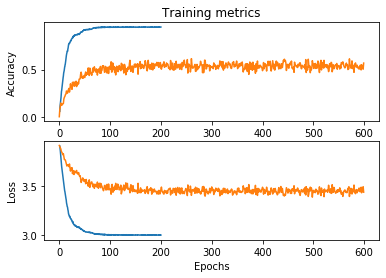

In [15]:
import matplotlib.pyplot as plt

x_axis = np.linspace(1,200,600)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()